In [1]:
import sys
from pathlib import Path

import h5py as h5
import numpy as np
import pandas as pd

sys.path.append('../lib')
from storage import get_storage_functions
from local_paths import preproc_dir, analysis_dir

# Set parameters

In [2]:
#============================================================================
# session
#============================================================================
sess_name = 'sess_name'


#============================================================================
# response windows
#============================================================================
t_pre  = 500
t_post = 500
t_win  = 200
t_step =  50


#============================================================================
# temporal resolution
#============================================================================
# for summarizing trial duration and iti
dur_res = 100
iti_res =  50
min_dur = 200  # exclude these before finding most-common (mode) trial dur


#============================================================================
# paths
#============================================================================
proc_dir = preproc_dir

output_dir = analysis_dir + 'trial_level_psth'

In [3]:
# Parameters
sess_name = "Pa210201"
output_dir = "../test_results"


# Check prereqs and params

In [4]:
preproc_main_path = Path(proc_dir) / (sess_name + '-main.nwb')
print('Loading session from', preproc_main_path)
preproc_main_path = preproc_main_path.expanduser()
assert preproc_main_path.is_file()

proc_path = Path(proc_dir) / (sess_name + '-proc.h5')
print('Loading shared processing from', proc_path)
proc_path = proc_path.expanduser()
assert proc_path.is_file()

rasters_path = Path(proc_dir) / (sess_name + '-rasters.nwb')
print('Loading rasters from', rasters_path)
rasters_path = rasters_path.expanduser()
assert rasters_path.is_file()

output_dir = Path(output_dir)
assert output_dir.expanduser().is_dir()
output_path = output_dir / (sess_name + '.h5')
print('Saving results to', output_path)
output_path = output_path.expanduser()

Loading session from ../test_data/Pa210201-main.nwb
Loading shared processing from ../test_data/Pa210201-proc.h5
Loading rasters from ../test_data/Pa210201-rasters.nwb
Saving results to ../test_results/Pa210201.h5


In [5]:
with h5.File(proc_path, 'r') as f:
    unit_names = f['unit_selection/simple'][()].astype(str)

In [6]:
analysis_name = 'trial_level_psth'

if output_path.is_file():
    with h5.File(output_path, 'r') as f:
        try:
            if f[f'progress_report/{analysis_name}/all_done'][()].item():
                raise RuntimeError(f'{sess_name} has already been processed')
        except KeyError:
            pass

# Save config

In [7]:
save_results, add_attr_to_dset, check_equals_saved, link_dsets, copy_group = \
    get_storage_functions(output_path)

In [8]:
group = analysis_name + '/config/time_windows/'
save_results(group+'t_pre', t_pre)
save_results(group+'t_post', t_post)
save_results(group+'t_win', t_win)
save_results(group+'t_step', t_step)
add_attr_to_dset(group, attrs=dict(unit='ms'))

# Select trials and fixations

In [9]:
with h5.File(preproc_main_path, 'r') as f:
    pres_iim = f['stimulus/presentation/presentations/data'][()]
    pres_tid = f['intervals/presentations/trial_id'][()]
    pres_t0s = f['intervals/presentations/start_time'][()]
    pres_t1s = f['intervals/presentations/stop_time'][()]

durs = (pres_t1s - pres_t0s) * 1e3
durs = np.round(durs / dur_res) * dur_res
dur = pd.Series(durs[durs > min_dur]).mode().values.mean().item()
dur = round(dur / dur_res) * dur_res
print('Mode trial duration:\t', dur, 'ms')

itis = (pres_t0s[1:] - pres_t1s[:-1]) * 1e3
itis = np.round(itis / iti_res) * iti_res
iti = pd.Series(itis).mode().values.mean().item()
iti = np.round(iti / iti_res) * iti_res
print('Mode ITI:\t\t', iti, 'ms')  # for the record only

# these are trial ID's
itr_sel = pres_tid[np.nonzero(durs == dur)[0]]
print('Selected', len(itr_sel), 'complete trials')

# these are trial indices, relative to pres_*
tr_sel = pd.DataFrame(data={'Trial': pres_tid, 'Index': np.arange(pres_tid.size)})\
    .set_index('Trial').loc[itr_sel, 'Index'].values

Mode trial duration:	 1500 ms
Mode ITI:		 800.0 ms
Selected 1605 complete trials


In [10]:
save_results(analysis_name+'/mode_dur', dur)
save_results(analysis_name+'/mode_iti', iti)
save_results(analysis_name+'/trial_selection', itr_sel)

# Get image onset-aligned responses

In [11]:
with h5.File(rasters_path, 'r') as f:
    all_unit_names = list(f['processing/ecephys/unit_names/unit_name'][()].astype(str))
    sel_ = np.array([all_unit_names.index(n) for n in unit_names])
    rasters = f['processing/ecephys/rasters/data'][()][:,sel_]
rasters.shape, rasters.dtype

((6234150, 92), dtype('uint8'))

In [12]:
ts = np.arange(-t_pre, dur+t_post, t_step)
hwin = t_win//2

resps = np.empty((itr_sel.size, ts.size, unit_names.size), dtype=np.float32)

for i, t0 in enumerate(pres_t0s[tr_sel]*1e3):
    for j, t in enumerate(np.round(t0 - hwin + ts).astype(int)):
        resps[i,j] = rasters[t:t+t_win,:].mean(0)

In [13]:
save_results(analysis_name+'/mean_responses', resps.mean(0)*1e3, attrs=dict(
    dims=np.array(['time', 'unit'], dtype=bytes),
    time=ts, unit=unit_names.astype(bytes), n_trial=len(resps)))

# Wrap up

In [14]:
save_results(f'progress_report/{analysis_name}/all_done', True)

In [15]:
%load_ext watermark
%watermark
%watermark -vm --iversions -rbg

Last updated: 2024-02-18T13:19:14.826442-05:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Git hash: b0bb10f45dee065cc3af96fe224326b883d27431

Git repo: https://github.com/willwx/free_viewing_staging.git

Git branch: master

pandas: 2.0.1
sys   : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
h5py  : 3.8.0
numpy : 1.24.3



# Plots

In [16]:
import matplotlib.pyplot as plt

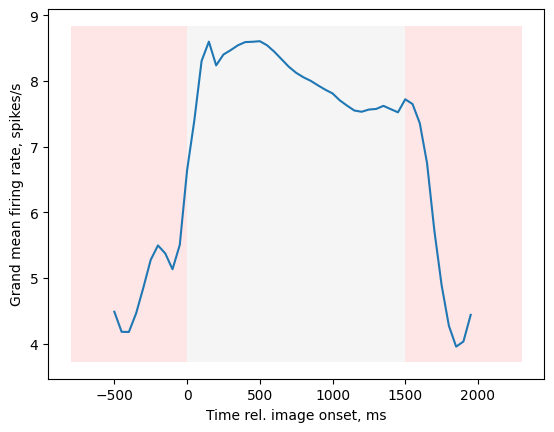

In [17]:
plt.plot(ts, resps.mean((0,-1)) * 1e3)

yl = plt.gca().get_ylim()
plt.fill_betweenx(yl, 0, dur, ec='none', fc='whitesmoke', zorder=-1)
plt.fill_betweenx(yl, dur, dur+iti, ec='none', fc=(1, .9, .9), zorder=-1)
plt.fill_betweenx(yl, -iti, 0, ec='none', fc=(1, .9, .9), zorder=-1)

plt.xlabel('Time rel. image onset, ms')
plt.ylabel('Grand mean firing rate, spikes/s');